#Trabalho Final

#### Dataset:
Sinistros de Trânsito Agrupados Por Ocorrência em 2007 (https://dados.gov.br/dados/conjuntos-dados/sinistros-de-transito-agrupados-por-ocorrencia) complementado pela estimativa da população de cada município em 2006 (https://www.ibge.gov.br/estatisticas/sociais/populacao/9103-estimativas-de-populacao.html?edicao=17283&t=downloads), integrados no arquivo sinistros2007.csv.

In [12]:
!pip install unidecode xlrd
import pandas as pd
import numpy as np
import re
import unidecode
import duckdb
import matplotlib.pyplot as plt
import seaborn as sns
con = duckdb.connect()
import scipy.stats as st
import statsmodels.formula.api as smf

In [13]:
df = pd.read_csv("sinistros2007.csv")
df.head()

,Unnamed: 0,id,data_inversa,dia_semana,horario,uf,br,km,municipio,causa_acidente,...,feridos_leves,feridos_graves,ilesos,ignorados,feridos,veiculos,pop_2006,hora,mes,fim_semana
0,0,1051130,12/02/2007,Segunda,02:10:00,MA,135,11.0,SAO LUIS,Animais na Pista,...,2,1,0,0,3,1,998385.0,2,2,False
1,1,1066824,20/11/2007,Ter�a,05:30:00,CE,222,30.8,CAUCAIA,Defeito mec�nico em ve�culo,...,1,0,0,0,1,1,313584.0,5,11,False
2,2,1333766,17/07/2007,Ter�a,14:00:00,GO,70,372.0,MONTES CLAROS DE GOIAS,Falta de aten��o,...,0,1,1,0,1,2,7652.0,14,7,False
3,3,173714,01/01/2007,Segunda,00:03:00,RJ,116,305.5,RESENDE,Animais na Pista,...,0,0,1,0,0,1,119729.0,0,1,False
4,4,173715,01/01/2007,Segunda,00:50:00,RJ,101,321.5,NITEROI,N�o guardar dist�ncia de seguran�a,...,0,0,2,0,0,2,476669.0,0,1,False


##3 Análise Exploratória e Consultas SQL

###3.2 Preparação dos Dados em Formato Tidy

In [14]:
df["data_inversa"] = pd.to_datetime(df["data_inversa"], format="%d/%m/%Y")

In [15]:
df["fim_semana"] = df["data_inversa"].dt.weekday
df["mes"] = df["data_inversa"].dt.month
df["dia"] = df["data_inversa"].dt.day

In [16]:
df.to_parquet("sinistros2007.parquet", index=False, compression="snappy")


###3.3 Consultas SQL Analíticas (5+ obrigatórias)

In [17]:
df.info()
con.register("sinistros2007", df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79811 entries, 0 to 79810
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Unnamed: 0              79811 non-null  int64         
 1   id                      79811 non-null  int64         
 2   data_inversa            79811 non-null  datetime64[ns]
 3   dia_semana              79811 non-null  object        
 4   horario                 79811 non-null  object        
 5   uf                      79811 non-null  object        
 6   br                      79811 non-null  int64         
 7   km                      79811 non-null  float64       
 8   municipio               79811 non-null  object        
 9   causa_acidente          79811 non-null  object        
 10  tipo_acidente           79811 non-null  object        
 11  classificacao_acidente  79811 non-null  object        
 12  fase_dia                79811 non-null  object

Tendências temporais: número diário de sinistros com média móvel


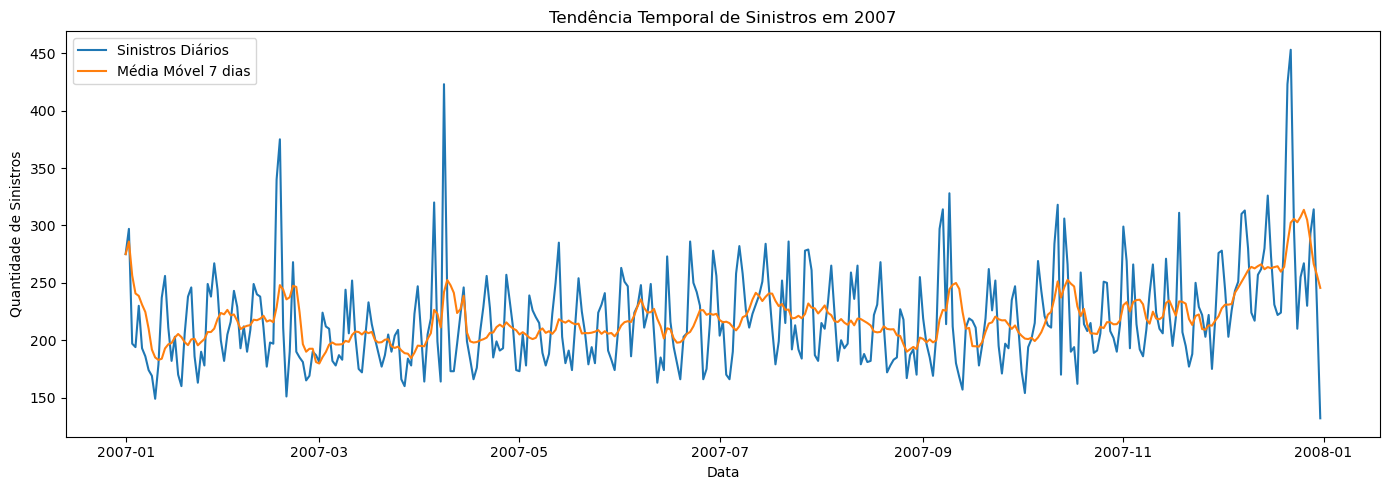

,dia,total_sinistros,media_movel_7d
0,2007-01-01,275,275.000000
1,2007-01-02,297,286.000000
2,2007-01-03,197,256.333333
3,2007-01-04,194,240.750000
4,2007-01-05,230,238.600000
...,...,...,...
360,2007-12-27,230,304.857143
361,2007-12-28,293,286.285714
362,2007-12-29,314,266.428571
363,2007-12-30,228,256.714286


In [18]:
print("Tendências temporais: número diário de sinistros com média móvel")
df_trend = con.execute("""
WITH diarios AS (
    SELECT
        CAST(data_inversa AS DATE) AS dia,
        COUNT(*) AS total_sinistros
    FROM sinistros2007
    GROUP BY CAST(data_inversa AS DATE)
)
SELECT
    dia,
    total_sinistros,
    AVG(total_sinistros) OVER (
        ORDER BY dia
        ROWS BETWEEN 6 PRECEDING AND CURRENT ROW
    ) AS media_movel_7d
FROM diarios
ORDER BY dia;

""").df()

plt.figure(figsize=(14, 5))
plt.plot(df_trend["dia"], df_trend["total_sinistros"], label="Sinistros Diários")
plt.plot(df_trend["dia"], df_trend["media_movel_7d"], label="Média Móvel 7 dias")
plt.xlabel("Data")
plt.ylabel("Quantidade de Sinistros")
plt.title("Tendência Temporal de Sinistros em 2007")
plt.legend()
plt.tight_layout()
plt.show()
df_trend

O número diário de sinistros com média móvel de 7 dias suaviza as variações diárias, permitindo observar o número de sinistros ao longo de períodos. Podemos observar que, no fim e no começo do ano, a quantidade de sinistros é mais elevada, com o restante do ano apresentando 4 picos. Seria conveniente evitar viagens nesses períodos do ano.

Comparação entre grupos: taxa de mortos por tipo de acidente


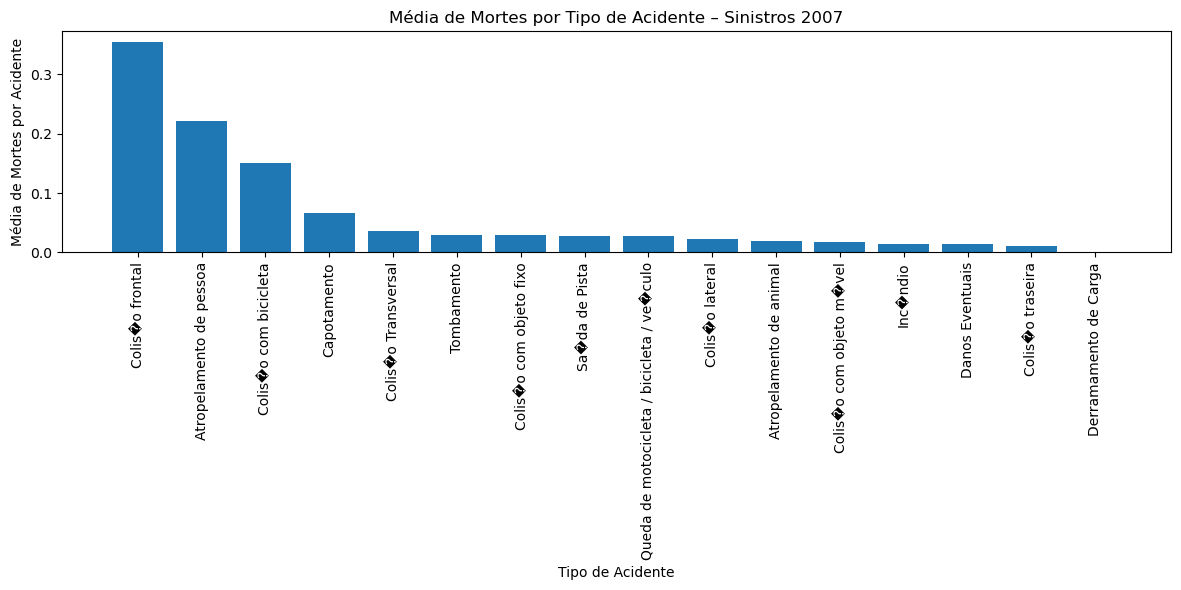

,tipo_acidente,ocorrencias,total_mortos,media_mortos_por_acidente
0,Colis�o frontal,2822,1002.0,0.355
1,Atropelamento de pessoa,1808,402.0,0.222
2,Colis�o com bicicleta,1618,242.0,0.150
3,Capotamento,3340,221.0,0.066
4,Colis�o Transversal,9303,338.0,0.036
5,Tombamento,3211,92.0,0.029
6,Colis�o com objeto fixo,3964,116.0,0.029
7,Sa�da de Pista,9577,264.0,0.028
8,Queda de motocicleta / bicicleta / ve�culo,1382,38.0,0.027
9,Colis�o lateral,13785,309.0,0.022


In [19]:
print("Comparação entre grupos: taxa de mortos por tipo de acidente")
df_tipo = con.execute("""
SELECT
    tipo_acidente,
    COUNT(*) AS ocorrencias,
    SUM(mortos) AS total_mortos,
    ROUND(SUM(mortos)::numeric / COUNT(*), 3) AS media_mortos_por_acidente
FROM sinistros2007
GROUP BY tipo_acidente
ORDER BY media_mortos_por_acidente DESC;

""").df()

plt.figure(figsize=(12, 6))
plt.bar(df_tipo["tipo_acidente"], df_tipo["media_mortos_por_acidente"])
plt.xticks(rotation=90)
plt.ylabel("Média de Mortes por Acidente")
plt.xlabel("Tipo de Acidente")
plt.title("Média de Mortes por Tipo de Acidente – Sinistros 2007")
plt.tight_layout()
plt.show()
df_tipo

A taxa de mortos por tipo de acidente mostra a letalidade de cada acidente. Os acidentes mais letais são colisão frontal, atropelamento de pessoa e colisão com bicicleta, logo, devem ser os mais evitados.

In [20]:
print("Análise de concentração (Pareto): 80% dos mortos vêm de quantas causas?")
con.execute("""

WITH base AS (
    SELECT
        causa_acidente,
        SUM(mortos) AS mortos
    FROM sinistros2007
    GROUP BY causa_acidente
),
ordenado AS (
    SELECT
        *,
        SUM(mortos) OVER (ORDER BY mortos DESC) AS acumulado,
        SUM(mortos) OVER () AS total
    FROM base
)
SELECT
    causa_acidente,
    mortos,
    acumulado,
    ROUND(acumulado / total, 3) AS perc_acumulado
FROM ordenado
ORDER BY mortos DESC;

""").df()

Análise de concentração (Pareto): 80% dos mortos vêm de quantas causas?


,causa_acidente,mortos,acumulado,perc_acumulado
0,Falta de aten��o,1436.0,1436.0,0.425
1,Velocidade incompat�vel,513.0,1949.0,0.577
2,Ultrapassagem indevida,494.0,2443.0,0.723
3,Dormindo,214.0,2657.0,0.786
4,Desobedi�ncia � sinaliza��o,209.0,2866.0,0.848
5,Ingest�o de �lcool,172.0,3038.0,0.899
6,Defeito mec�nico em ve�culo,117.0,3155.0,0.933
7,Animais na Pista,96.0,3251.0,0.962
8,N�o guardar dist�ncia de seguran�a,65.0,3316.0,0.981
9,Defeito na via,64.0,3380.0,1.000


Podemos observar que 80% das mortes vêm de 5 causas (falta de atenção, velocidade incompatível, ultrapassagem indevida, dormindo e desobediência à sinalização), evidenciando as principais causas a serem combatidas.

In [21]:
print("Detecção de anomalias: dias com número atípico de acidentes (Z-Score)")
con.execute("""

WITH diarios AS (
    SELECT
        data_inversa::date AS dia,
        COUNT(*) AS total_sinistros
    FROM sinistros2007
    GROUP BY dia, data_inversa
),
stats AS (
    SELECT
        AVG(total_sinistros) AS media,
        STDDEV_POP(total_sinistros) AS sd
    FROM diarios
)
SELECT
    d.*,
    (d.total_sinistros - s.media) / s.sd AS z_score
FROM diarios d CROSS JOIN stats s
WHERE ABS((d.total_sinistros - s.media) / s.sd) > 2.5
ORDER BY z_score DESC;

""").df()

Detecção de anomalias: dias com número atípico de acidentes (Z-Score)


,dia,total_sinistros,z_score
0,2007-12-22,453,5.442866
1,2007-04-08,423,4.746075
2,2007-12-21,423,4.746075
3,2007-02-17,375,3.631208
4,2007-02-16,340,2.818284
5,2007-09-09,328,2.539567


Os dias com número atípico de acidentes encontrados estão próximos de datas comemorativas, como o Natal (21 e 22 de dezembro), o Carnaval (16 e 17 de fevereiro), a Independência (9 de stembro) e a Páscoa (8 de abril).

Correlações e dependências: relação entre número de veículos e gravidade


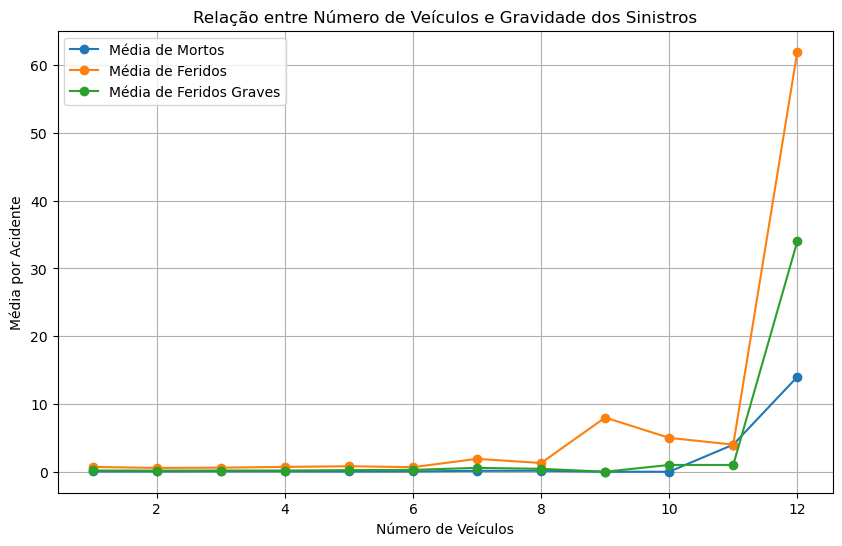

,veiculos,media_mortos,media_feridos,media_graves
0,1,0.042032,0.705667,0.184799
1,2,0.039514,0.558791,0.162457
2,3,0.061627,0.599330,0.174642
3,4,0.056502,0.713004,0.178475
4,5,0.036496,0.810219,0.233577
5,6,0.039474,0.671053,0.276316
6,7,0.133333,1.900000,0.566667
7,8,0.142857,1.285714,0.428571
8,9,0.000000,8.000000,0.000000
9,10,0.000000,5.000000,1.000000


In [22]:
print("Correlações e dependências: relação entre número de veículos e gravidade")
df_cor = con.execute("""

SELECT
    veiculos,
    AVG(mortos) AS media_mortos,
    AVG(feridos) AS media_feridos,
    AVG(feridos_graves) AS media_graves
FROM sinistros2007
GROUP BY veiculos
HAVING veiculos <= 15
ORDER BY veiculos;

""").df()

plt.figure(figsize=(10, 6))

plt.plot(df_cor["veiculos"], df_cor["media_mortos"], marker="o", label="Média de Mortos")
plt.plot(df_cor["veiculos"], df_cor["media_feridos"], marker="o", label="Média de Feridos")
plt.plot(df_cor["veiculos"], df_cor["media_graves"], marker="o", label="Média de Feridos Graves")

plt.xlabel("Número de Veículos")
plt.ylabel("Média por Acidente")
plt.title("Relação entre Número de Veículos e Gravidade dos Sinistros")
plt.legend()
plt.grid(True)

plt.show()
df_cor

Avaliando a relação entre número de veículos e gravidade, verificamos que os sinistros com maior número de pessoas afetadas, seja feridas, feridas graves ou mortas, ocorem com o maior número de veículos envolvidos.

###3.4 Análise Exploratória e Teste de Hipóteses

####Análise univariada

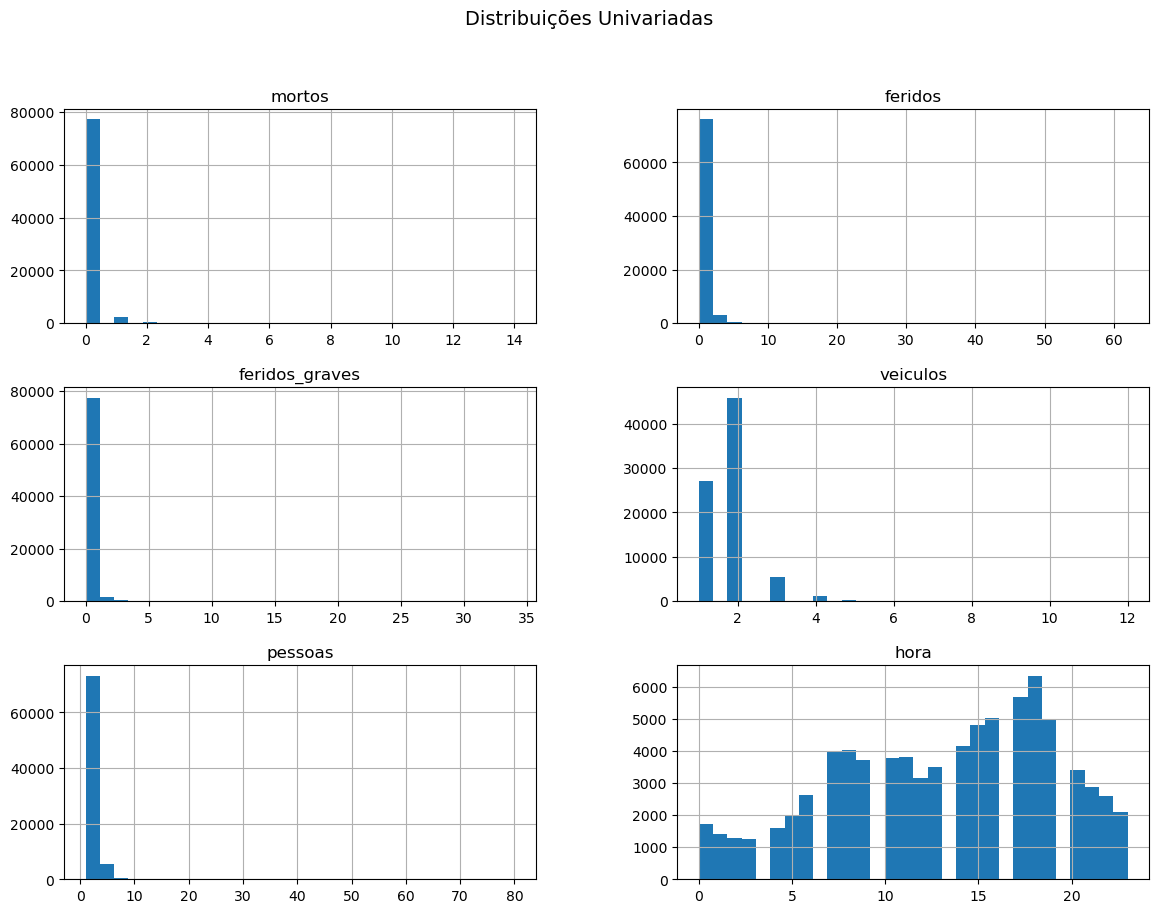

In [33]:
cols_num = ["mortos", "feridos", "feridos_graves", "veiculos", "pessoas", "hora"]

df[cols_num].hist(figsize=(14, 10), bins=30)
plt.suptitle("Distribuições Univariadas", fontsize=14)
plt.show()


Observamos que o número de feridos e mortos em sua grande maioria é zero, com o número de pessoas envolvidas sendo normalmente 1. Na hora, observamos que no período da madrugada ocorrem menos sinistros, que tem seu pico no fim da tarde, início da noite. 

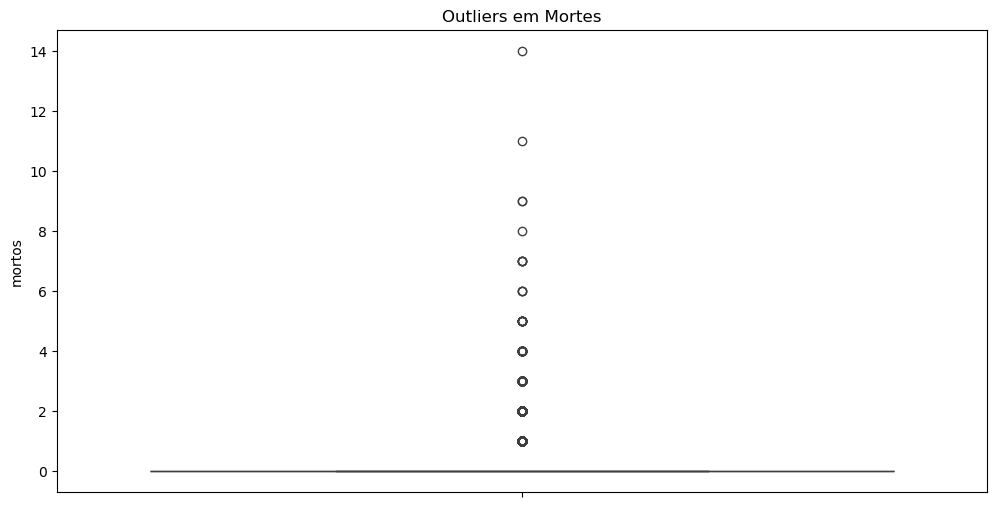

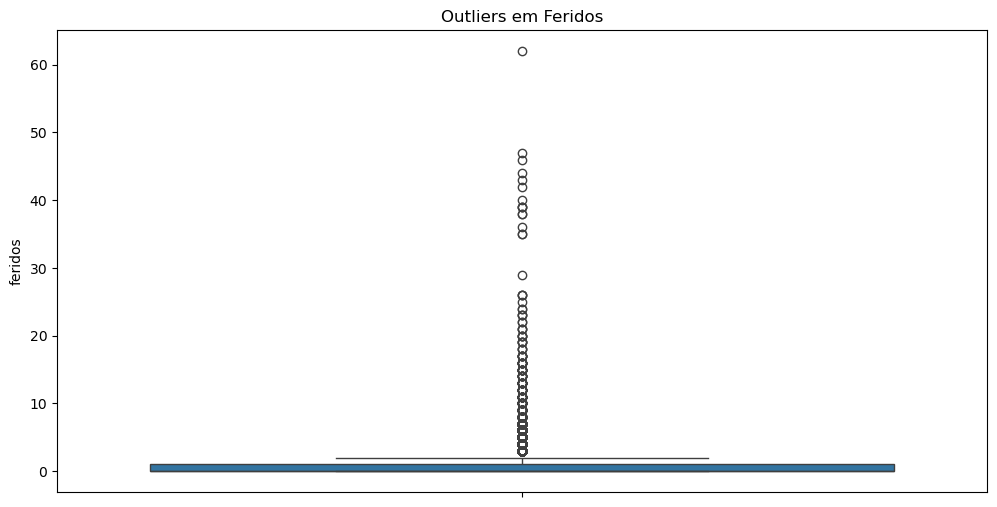

In [24]:
plt.figure(figsize=(12, 6))
sns.boxplot(df["mortos"])
plt.title("Outliers em Mortes")
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(df["feridos"])
plt.title("Outliers em Feridos")
plt.show()

Verificamos que os outliers são pequenos, não são valores absurdos que só podem ser originados de erros. Optamos por mantê-los e avaliar seu impacto nos modelos.

####Análise bivariada

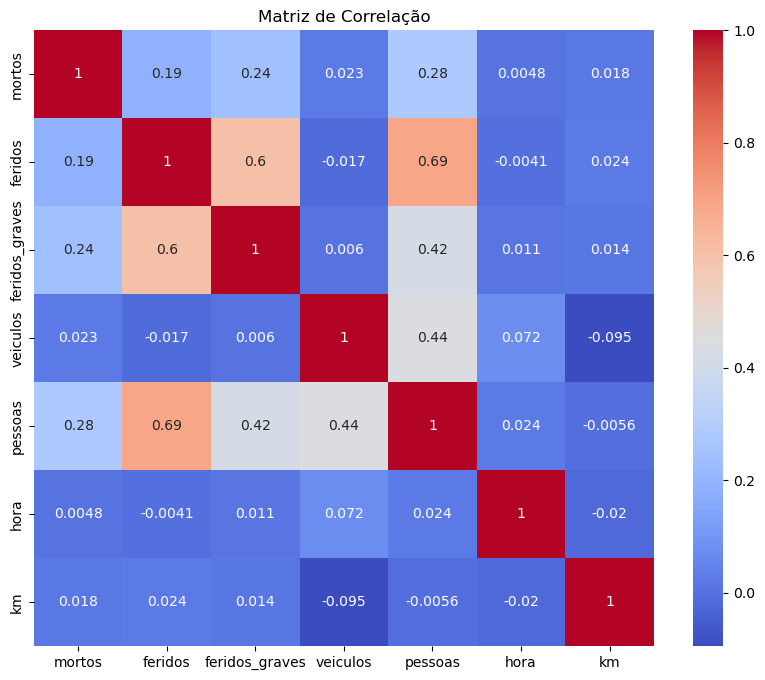

In [25]:
plt.figure(figsize=(10, 8))
sns.heatmap(df[cols_num].corr(), annot=True, cmap="coolwarm")
plt.title("Matriz de Correlação")
plt.show()

Verificamos correlações altas entre váriaveis numéricas que se somam, como feridos_graves com feridos e pessoas com feridos. Exitem também correlações significativas entre pessoas e veiculos.

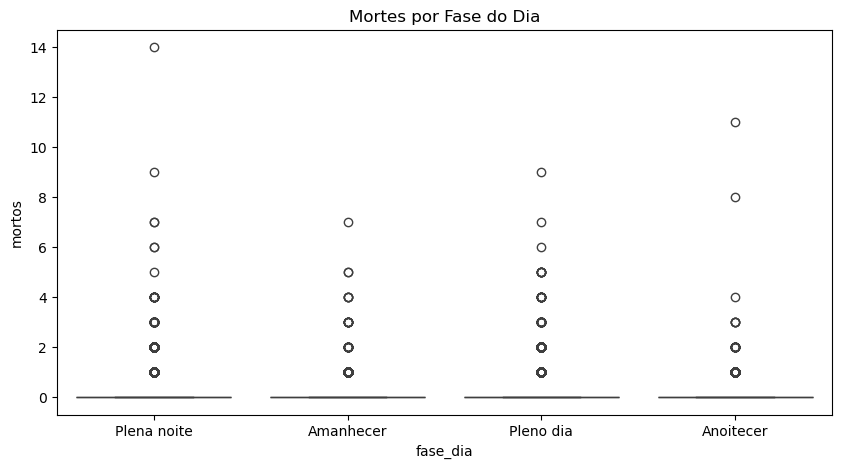

In [26]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df, x="fase_dia", y="mortos")
plt.title("Mortes por Fase do Dia")
plt.show()

Não verificamos outliers significativos.

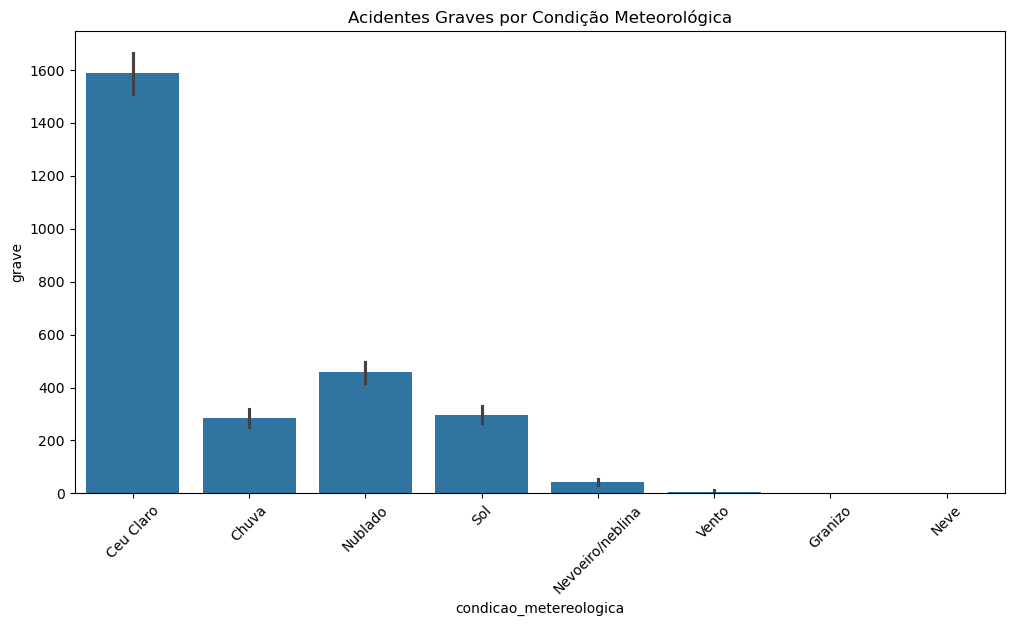

In [27]:
df["grave"] = (df["mortos"] > 0).astype(int)

plt.figure(figsize=(12,6))
sns.barplot(data=df, x="condicao_metereologica", y="grave", estimator=sum)
plt.xticks(rotation=45)
plt.title("Acidentes Graves por Condição Meteorológica")
plt.show()

Verificamos que a maior parte dos sinistros graves acontece com céu claro.

####Análise multivariada

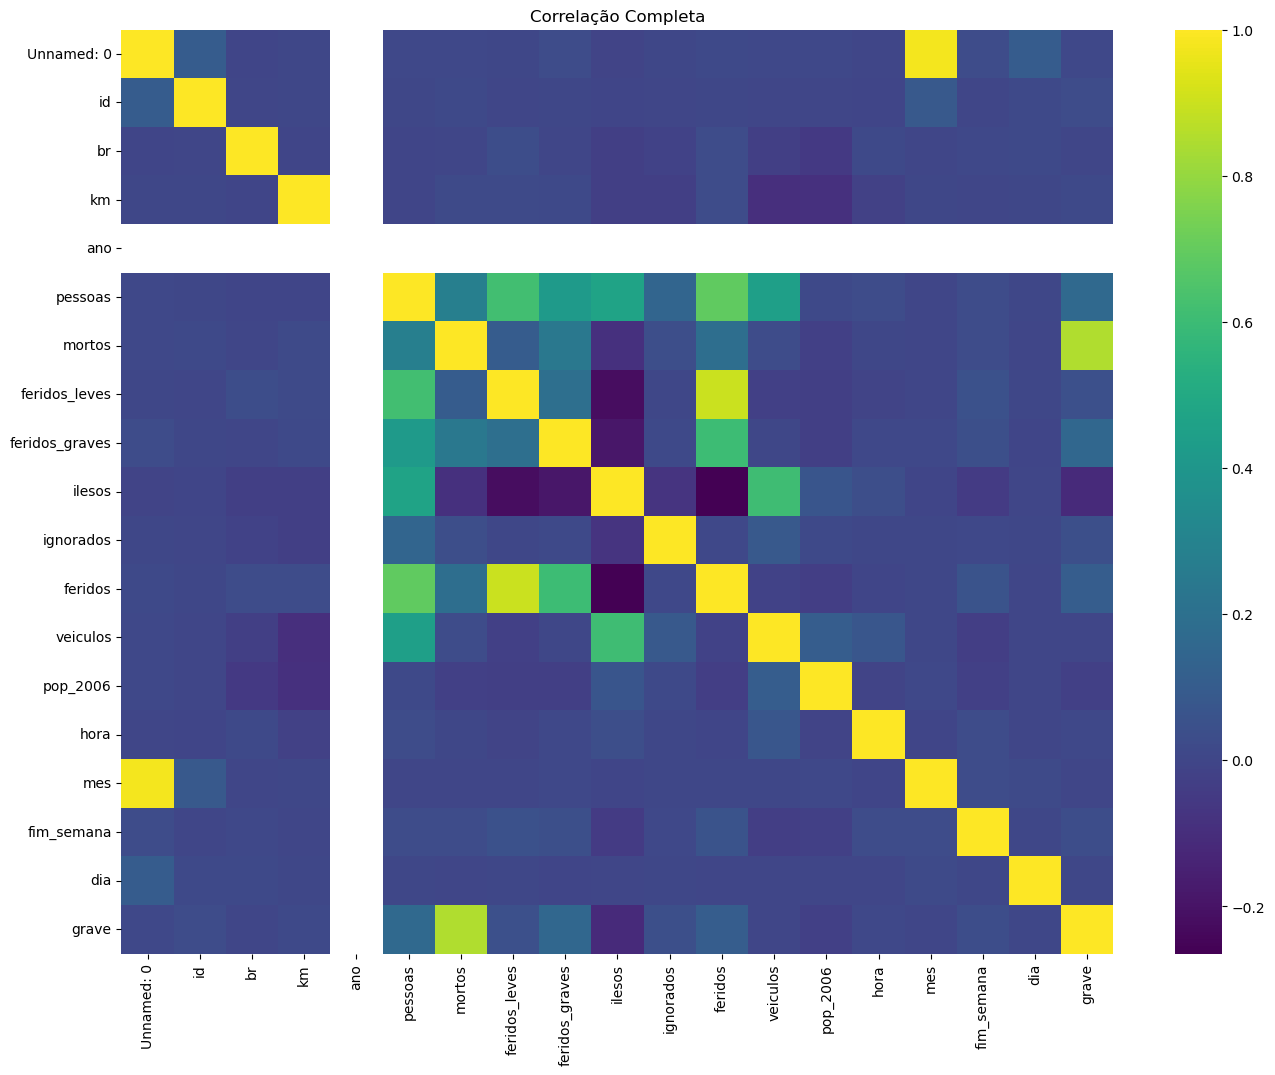

In [28]:
plt.figure(figsize=(16, 12))
sns.heatmap(df.corr(numeric_only=True), cmap="viridis")
plt.title("Correlação Completa")
plt.show()

Verificamos correlações altas entre váriaveis numéricas relacionadas, como o número de pessoas e o número de feridos. Existe grande corelação entre mortos e a gravidade.

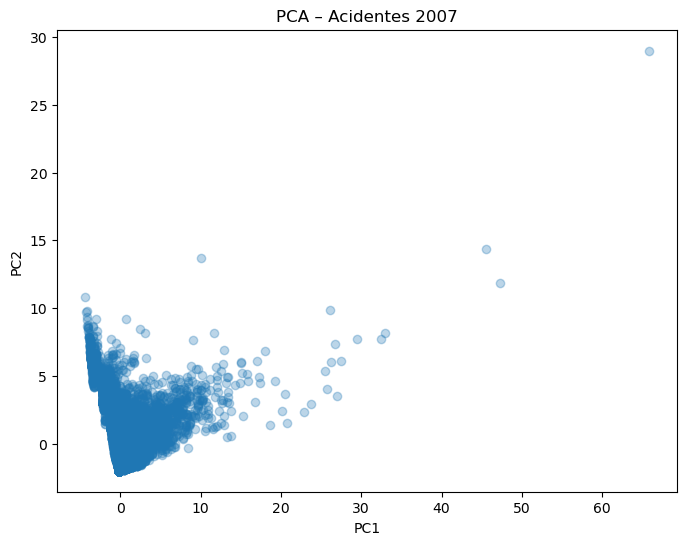

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

features = ["veiculos", "mortos", "feridos", "hora", "pop_2006"]
df_clean = df[features].dropna()

scaler = StandardScaler()
X = scaler.fit_transform(df_clean)

pca = PCA(n_components=2)
components = pca.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(components[:,0], components[:,1], alpha=0.3)
plt.title("PCA – Acidentes 2007")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

Os pontos estão concentrados em apenas uma região, indicando que são parecidos em relação as colunas usadas (veículos, mortos, feridos, hora, pop_2006). Existem alguns pontos que fogem dessa região, outliers. A escala maior de PC1 indica que ele explora melhor a variação dos dados.

####Teste de hipóteses

H1: Fatores ambientais e temporais influenciam a gravidade do sinistro

In [30]:
groups = [g["mortos"].values for _, g in df.groupby("fase_dia")]
f_stat, p_value = st.f_oneway(*groups)
print("ANOVA mortos ~ fase_dia:", p_value)

ANOVA mortos ~ fase_dia: 3.8233613031366624e-47


In [31]:
tabela = pd.crosstab(df["condicao_metereologica"], df["grave"])
chi2, p, dof, exp = st.chi2_contingency(tabela)

print("Qui-quadrado clima × gravidade:", p)

Qui-quadrado clima × gravidade: 3.5852705469560646e-17


O valor-p gerado pela ANOVA entre mortos e fase_dia indica que a gravidade dos acidentes varia de forma estatisticamente significativa conforme o período do dia, sugerindo que apresentam níveis diferentes de letalidade. O teste qui-quadrado entre clima e gravidade demonstra uma associação altamente significativa entre condições climáticas e severidade do acidente, reforçando que fatores como chuva, neblina ou pista seca influenciam a probabilidade de um sinistro ser mais ou menos grave. Ambos os resultados apoiam fortemente a hipótese H1, mostrando que tanto variáveis temporais quanto ambientais têm efeito substancial e não aleatório sobre a gravidade dos acidentes analisados.

H2: O número de veículos envolvidos e o tipo de pista são preditores significativos da
gravidade

In [32]:


df["grave"] = (df["mortos"] > 0).astype(int)
modelo = smf.logit("grave ~ veiculos + C(tipo_pista)", data=df).fit()
print(modelo.summary())

Optimization terminated successfully.
         Current function value: 0.144459
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  grave   No. Observations:                79811
Model:                          Logit   Df Residuals:                    79807
Method:                           MLE   Df Model:                            3
Date:                Wed, 26 Nov 2025   Pseudo R-squ.:                 0.01625
Time:                        18:21:27   Log-Likelihood:                -11529.
converged:                       True   LL-Null:                       -11720.
Covariance Type:            nonrobust   LLR p-value:                 2.871e-82
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -3.9599      0.068    -58.225      0.000      -4.

Os resultados da regressão logística mostram que o modelo é altamente significativo, indicando que, as variáveis incluídas explicam de forma estatisticamente robusta a probabilidade de um acidente ser grave. Individualmente, vemos que tanto o tipo de pista quanto o número de veículos são preditores significativos da gravidade. Acidentes em pistas simples aumentam a chance de gravidade, enquanto pistas múltiplas reduzem essa probabilidade. Além disso, o número de veículos tem efeito positivo e significativo, indicando que cada veículo adicional aumenta a probabilidade de o acidente ser classificado como grave. Assim, os resultados apoiam diretamente a hipótese H2, demonstrando que tanto o tipo da pista quanto a quantidade de veículos influenciam significativamente a gravidade do sinistro, ainda que o poder explicativo do modelo (Pseudo R = 0.016) seja pequeno, comum em modelos logísticos em dados reais de acidentes.